In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mcerp import correlate, correlation_matrix, plotcorr
from mcerp import Beta, N, Exp, PERT
from mcerp import uv, stats
# from mcerp import *

from scipy import stats as stats
from scipy.stats import rv_continuous, beta, genextreme, rv_histogram
import scipy.optimize as opt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

nR = 10000

# Simulation without correlations

In [28]:
# distribution parameters:
min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0         # sales volume, PERT estimae
ms, ss = 20.0, 1.0                                          # selling price, normally distributed
mm, sm = 13.0, 0.7                                          # material unit cost, normally distributed 
o = 3.0                                                     # other unit cost, deterministic    

In [29]:
# setting up the simulation model BEFORE calibrating correlations:

# input variables:
v1 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p1 = N(ms, ss)                                  # selling price, normally distributed
m1 = N(mm, sm)                                  # material unit cost, normally distributed 
o1 = o                                          # other unit cost, deterministic    


# output variables:
GP1 = v1 * (p1 - m1 - o1)                       # simulation output: Gross Profit
R1 = v1 * p1                                    # simulation output: Revenues
GM1 = GP1 / R1                                  # simulation output: Gross Margin
C1 = R1 - GP1                                   # simulation output: Total Cost


In [30]:
# run the simulation model, 
# and collect the results in array variables

# number of mcerp samples
npts = nR

# assign the 6x 10,000 values to 6 variables so we can process their arrays later
rv1 = v1._mcpts
rp1 = p1._mcpts
rm1 = m1._mcpts
rGP1 = GP1._mcpts
rR1 = R1._mcpts
rGM1 = GM1._mcpts

# combine the 6 arrays in a 2-dimensional array
rand1 = np.vstack((rv1, rp1, rm1, rGP1, rR1, rGM1))

# copy the array to a dataframe for a more transparent layout
df1 = pd.DataFrame(data=rand1).T 
df1.rename(columns={ 
    0:"volume 1", 1:"price 1", 2:"material 1", 3:"Gross Profit 1", 4:"Revenues 1", 5:"Gross Margin 1"}, 
    inplace=True)
df1


,volume 1,price 1,material 1,Gross Profit 1,Revenues 1,Gross Margin 1
0,14707.231,20.200,12.241,72932.843,297083.711,0.245
1,8524.257,21.000,12.629,45777.230,179005.740,0.256
2,12573.245,21.702,14.218,56385.952,272866.763,0.207
3,9474.468,20.682,13.838,36412.236,195946.652,0.186
4,13345.322,21.307,12.896,72207.257,284342.243,0.254
...,...,...,...,...,...,...
9995,13705.622,20.131,12.697,60765.883,275906.582,0.220
9996,12834.454,20.837,13.119,60547.844,267425.939,0.226
9997,15304.410,21.285,12.334,91074.026,325756.756,0.280
9998,13278.438,18.709,12.744,39363.217,248422.778,0.158


In [31]:
# helper function: plot histogram
def plot_hist(data, title):
    hist = np.histogram(data, bins=100)
    histdist = rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    plt.title(title)
    plt.hist(data, density=True, bins=100)
    plt.plot(X, histdist.pdf(X))
    plt.show()

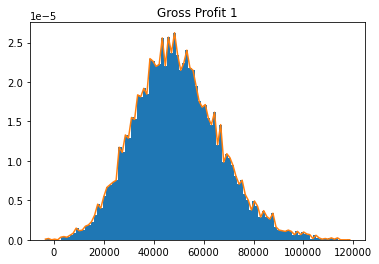

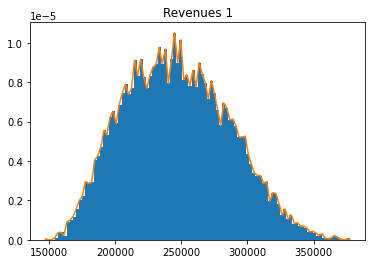

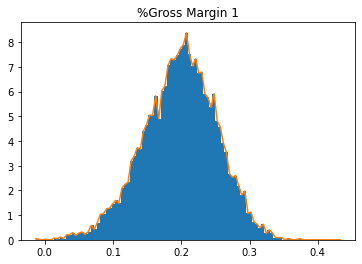

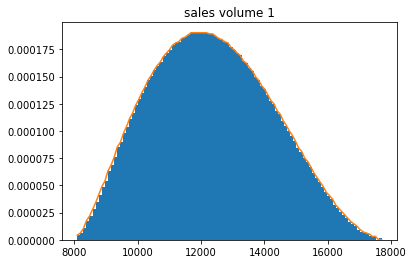

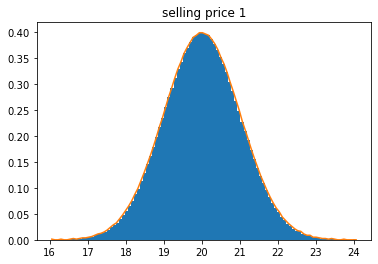

In [32]:
# results: draw histograms
plot_hist(rGP1, "Gross Profit 1")
plot_hist(rR1, "Revenues 1")
plot_hist(rGM1, "%Gross Margin 1")
plot_hist(rv1, "sales volume 1")
plot_hist(rp1, "selling price 1")


In [33]:
# distribution properties of the inputs: moments
def input_moments(v, p, m):
    # simulation inputs: moments
    print("sales volume:")
    v1.describe()
    print("selling price:")
    p1.describe()
    print("raw material unit cost:")
    m1.describe()

In [34]:
# simulation output: moments
def output_moments(GP, R, GM, C):
    print("Gross Profit:")
    GP1.describe()
    print("Revenues:")
    R1.describe()
    print("Gross Margin:")
    GM1.describe()
    print("Total Cost:")
    C1.describe()

In [35]:
# get the simulation results:
inmom1 = input_moments(v1, p1, m1)
inmom1


sales volume:
MCERP Uncertain Value:
 > Mean...................  12333.337795559159
 > Variance...............  3507929.767462387
 > Skewness Coefficient...  0.17798665305996422
 > Kurtosis Coefficient...  2.3755327677538243

selling price:
MCERP Uncertain Value:
 > Mean...................  20.000031612573984
 > Variance...............  1.0000492283015674
 > Skewness Coefficient...  0.0010900575901736146
 > Kurtosis Coefficient...  3.000853862602689

raw material unit cost:
MCERP Uncertain Value:
 > Mean...................  12.999987766444558
 > Variance...............  0.48994252925449694
 > Skewness Coefficient... -0.0008158037205103716
 > Kurtosis Coefficient...  2.9969671129998314



In [36]:
# get the simulation results:
outmom1 = output_moments(GP1, R1, GM1, C1)
outmom1

Gross Profit:
MCERP Uncertain Value:
 > Mean...................  49334.76645287035
 > Variance...............  286171779.0073335
 > Skewness Coefficient...  0.3266313226384609
 > Kurtosis Coefficient...  3.1613150493671403

Revenues:
MCERP Uncertain Value:
 > Mean...................  246642.42073383875
 > Variance...............  1544867504.2074015
 > Skewness Coefficient...  0.22318504548355922
 > Kurtosis Coefficient...  2.507287898989073

Gross Margin:
MCERP Uncertain Value:
 > Mean...................  0.19799932634921052
 > Variance...............  0.002845496524515435
 > Skewness Coefficient... -0.22144774175980256
 > Kurtosis Coefficient...  3.0801003473403537

Total Cost:
MCERP Uncertain Value:
 > Mean...................  197307.6542809684
 > Variance...............  963289215.8446301
 > Skewness Coefficient...  0.21715016955379904
 > Kurtosis Coefficient...  2.5057574871165236



In [37]:
# get the correlation matrix BEFORE recalibrating
c1 = correlation_matrix([v1, p1, m1])
c1

array([[ 1.   , -0.013, -0.02 ],
       [-0.013,  1.   ,  0.008],
       [-0.02 ,  0.008,  1.   ]])

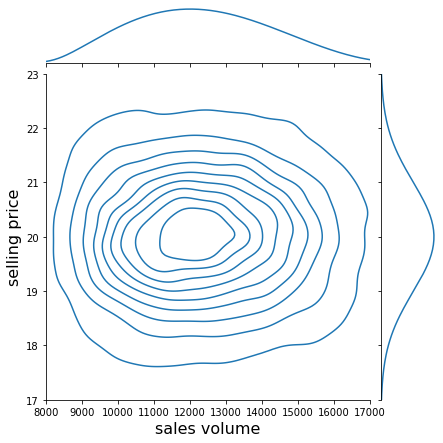

In [38]:
h = sns.jointplot(rv1, rp1, kind='kde', xlim=(8000, 17000), ylim=(17, 23), stat_func=None);
h.set_axis_labels('sales volume', 'selling price', fontsize=16);

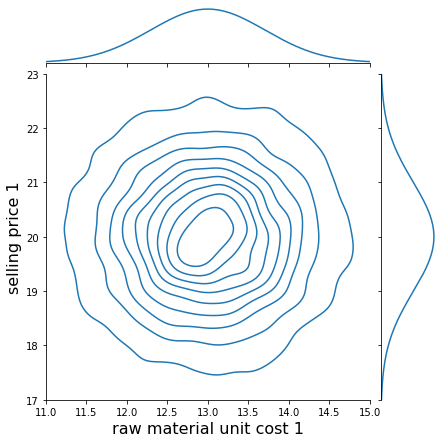

In [39]:
h = sns.jointplot(rm1, rp1, kind='kde', xlim=(11, 15), ylim=(17, 23), stat_func=None);
h.set_axis_labels('raw material unit cost 1', 'selling price 1', fontsize=16);

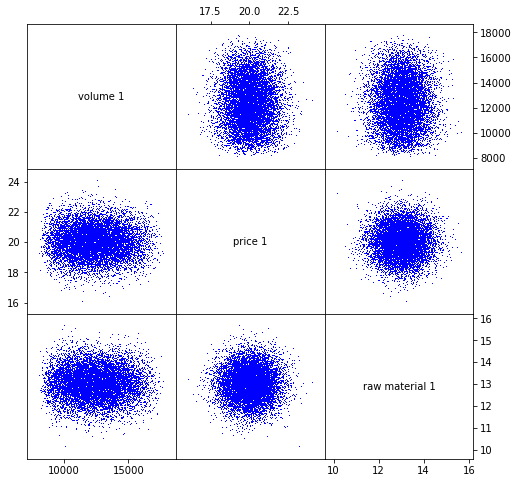

In [40]:
# plot correlations BEFORE recalibrating
corrplot0 = plotcorr([v1, p1, m1], labels=["volume 1", "price 1", "raw material 1"])

In [41]:
mean1 = GP1.mean
std1 = GP1.std
skew1 = GP1.skew
kurt1 = GP1.kurt
moments1 = [mean1, std1, skew1, kurt1]

# Impose different correlations

In [42]:
# targeted correlation matrix: volume, price, material unit cost
c_target = np.array(    [[  1.0, -0.3,  0.2],
                        [  -0.3,  1.0,  0.7],
                        [   0.2,  0.7,  1.0]])

In [43]:
v2 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p2 = N(ms, ss)                                  # selling price, normally distributed
m2 = N(mm, sm)                                  # material unit cost, normally distributed 
o2 = o                                          # other unit cost, deterministic    

In [44]:
# impose the targeted correlation matrix on the 3 input variables
correlate([v2, p2, m2], c_target)


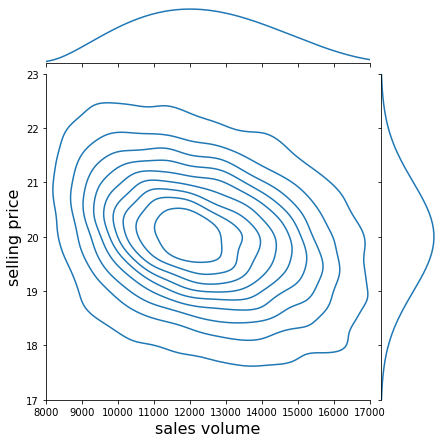

In [45]:
h = sns.jointplot(v2._mcpts, p2._mcpts, kind='kde', xlim=(8000, 17000), ylim=(17, 23), stat_func=None);
h.set_axis_labels('sales volume', 'selling price', fontsize=16);

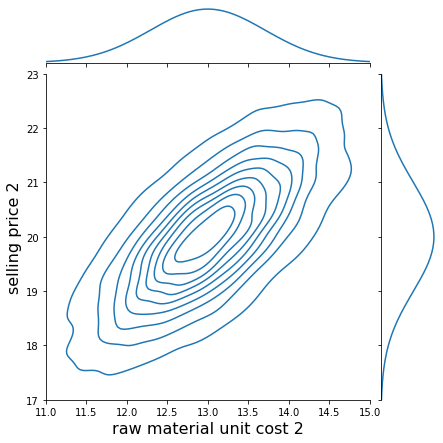

In [46]:
h = sns.jointplot(rm2, rp2, kind='kde', xlim=(11, 15), ylim=(17, 23), stat_func=None);
h.set_axis_labels('raw material unit cost 2', 'selling price 2', fontsize=16);

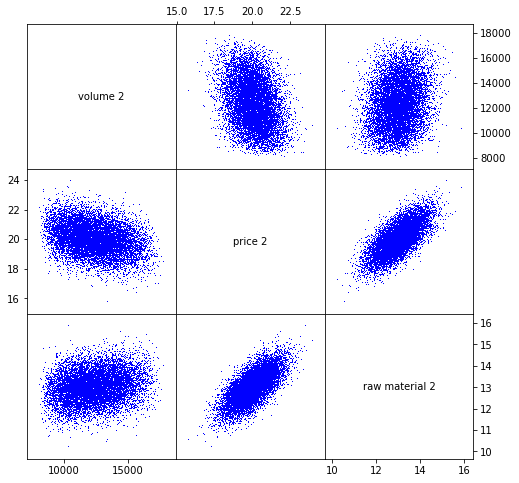

In [47]:
# plot the new correlation matrix of the input variables
corrplot2 = plotcorr([v2, p2, m2], labels=["volume 2", "price 2", "raw material 2"])

In [48]:
# check the new correlation matrix for the 3 input variables
c2 = correlation_matrix([v2, p2, m2])
c2

array([[ 1.   , -0.298,  0.199],
       [-0.298,  1.   ,  0.7  ],
       [ 0.199,  0.7  ,  1.   ]])

In [49]:
# deviations from targeted correlations?
c2 - c_target

array([[ 0.   ,  0.002, -0.001],
       [ 0.002,  0.   ,  0.   ],
       [-0.001,  0.   ,  0.   ]])

In [50]:
# induced changes vs original correlations
c2 - c1

array([[ 0.   , -0.285,  0.219],
       [-0.285,  0.   ,  0.692],
       [ 0.219,  0.692,  0.   ]])

In [51]:
# output variables:
# we rename the output variables to use consistent variable names in simu1 and simu2
GP2 = v2 * (p2 - m2 - o2)                       # simulation output: Gross Profit
R2 = v2 * p2                                    # simulation output: Revenues
GM2 = GP2 / R2                                  # simulation output: Gross Margin
C2 = R2 - GP2                                   # simulation output: Total Cost

In [52]:
# assign the 6x 10,000 variates to 6 variables so we can process their arrays later
rv2 = v2._mcpts
rp2 = p2._mcpts
rm2 = m2._mcpts
rGP2 = GP2._mcpts
rR2 = R2._mcpts
rGM2 = GM2._mcpts

# combine the 6 arrays in a 2-dimensional array
rand2 = np.vstack((rv2, rp2, rm2, rGP2, rR2, rGM2))

# copy the array to a dataframe for a more transparent layout
df2 = pd.DataFrame(data=rand2).T 
df2.rename(columns={ 
    0:"volume 2", 1:"price 2", 2:"material 2", 3:"Gross Profit 2", 4:"Revenues 2", 5:"Gross Margin 2"}, 
    inplace=True)
df2

,volume 2,price 2,material 2,Gross Profit 2,Revenues 2,Gross Margin 2
0,15087.898,18.570,12.467,46818.954,280180.918,0.167
1,11352.388,19.957,13.328,41197.195,226558.712,0.182
2,13205.322,21.521,13.581,65223.305,284186.559,0.230
3,13647.895,20.008,13.263,51110.186,273065.086,0.187
4,10433.825,19.533,11.639,51059.139,203799.095,0.251
...,...,...,...,...,...,...
9995,16108.376,19.275,13.362,46928.447,310494.855,0.151
9996,12358.358,19.949,13.528,42277.897,246541.834,0.171
9997,9833.396,19.972,12.821,40818.042,196393.055,0.208
9998,15588.838,21.474,15.290,49640.115,334756.592,0.148


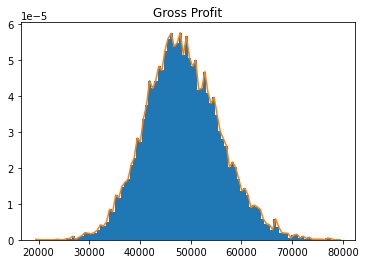

In [53]:
# results: draw histograms
plot_hist(rGP2, "Gross Profit")


In [54]:
# compare the main moments of the Gross Profit variable between the 2 simulation models:
moments_names = ["mean", "std", "skew", "kurt"]
moments2 = [GP2.mean, GP2.std, GP2.skew, GP2.kurt]

df = pd.DataFrame([moments1, moments2], columns=moments_names).T
df.rename(columns={0:"before", 1:"after"}, inplace=True)
df["variance"] = df["after"] - df["before"] 
df["%var"] = df["variance"] / df["before"] 
print("Moments of Gross Profit target variable: before vs after recalibrating correlations:")
df

Moments of Gross Profit target variable: before vs after recalibrating correlations:


,before,after,variance,%var
mean,49334.766,48513.327,-821.439,-0.017
std,16916.613,7354.570,-9562.042,-0.565
skew,0.327,0.232,-0.095,-0.291
kurt,3.161,3.156,-0.005,-0.002


In [55]:
    # quantiles of Gross Profit:
    q1 = np.array([0.001, 0.01, 0.99, 0.999])
    q2 = np.arange(0.05, 0.95, 0.05)
    q = np.concatenate((q1,q2))
    q.sort()
    xq = np.quantile(rGP2, q)
    
    qstr = [str(f'{v:.3f}') for v in q]
    dict_quantiles = dict(zip(qstr, xq))
    print("\nquantiles:")
    _ = [print(q,":",f'{xq:,.0f}') for q,xq in dict_quantiles.items()]


quantiles:
0.001 : 27,008
0.010 : 32,499
0.050 : 36,902
0.100 : 39,429
0.150 : 41,110
0.200 : 42,303
0.250 : 43,464
0.300 : 44,510
0.350 : 45,458
0.400 : 46,354
0.450 : 47,242
0.500 : 48,119
0.550 : 49,098
0.600 : 50,016
0.650 : 51,019
0.700 : 52,173
0.750 : 53,307
0.800 : 54,585
0.850 : 56,068
0.900 : 58,082
0.990 : 66,926
0.999 : 73,460
